En este trabajo se implementó un modelo de lenguaje basado en LSTM, entrenado sobre texto tokenizado por caracteres. La elección de LSTM se fundamenta en su capacidad para aprender dependencias a largo plazo, lo que la convierte en una opción más robusta que una RNN simple para tareas de generación de texto.

El modelo logró generar secuencias coherentes y estructuradas, y se evaluó su desempeño mediante la métrica de perplejidad. Además, se exploraron distintas estrategias de generación como greedy search y beam search con ajuste de temperatura, observando cómo estas afectan la diversidad y fluidez del texto generado

## 🔁 Recuperación de modelo y métricas guardadas

Este notebook comienza en modo recuperación. El modelo ya fue entrenado previamente y guardado como `best_model_lstm.keras`, junto con sus métricas de entrenamiento (`loss_history.npy`, `history_ppl.npy`, `best_epoch.npy`, `best_ppl.npy`).

Cargaue estos archivos para visualizar los gráficos de evolución y generar texto sin necesidad de reentrenar.

Esto garantiza reproducibilidad, eficiencia y claridad en la presentación de resultados.


# Recuperación y reutilización

# Recuperar best modelo y métricas

In [ ]:
"""
📦 BLOQUE DE RECUPERACIÓN

Este bloque carga el modelo previamente entrenado y todas las métricas guardadas,
permite visualizar los gráficos y generar texto sin necesidad de reentrenar.
"""

# Cargar métricas
history_ppl = np.load("history_ppl.npy").tolist()
loss_history = np.load("loss_history.npy").tolist()
best_epoch = int(np.load("best_epoch.npy"))
best_ppl = float(np.load("best_ppl.npy"))

# Cargar modelo
model_best_lstm = load_model("best_model_lstm.keras")
print(f"✅ Modelo cargado: 'best_model_lstm.keras' con PPL mínima de {best_ppl:.4f} en la época {best_epoch}")


# Recuperar gráficos

In [ ]:
# 📊 Visualización de métricas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 📉 Pérdida en entrenamiento
axs[0].plot(loss_history, marker='o', color='darkorange')
axs[0].set_title("📊 Evolución de la Pérdida en Entrenamiento")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# 📈 Perplejidad en validación
axs[1].plot(history_ppl, marker='o', color='teal', label='PPL por época')
axs[1].scatter(best_epoch, best_ppl, color='red', zorder=5)
axs[1].text(best_epoch, best_ppl + 0.5, '💾 Saved', color='red', ha='center', fontsize=10)
axs[1].set_title("📉 Evolución de la Perplejidad en Validación")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Perplejidad (PPL)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.savefig("grafico_loss_y_perplejidad_lstm.png")
plt.show()


# Recuperar y mostrar el texto en Gradio

In [ ]:
import gradio as gr

def recuperar_texto_guardado():
    with open("salida_generada_lstm.txt", "r", encoding="utf-8") as f:
        return f.read()

gr.Interface(
    fn=recuperar_texto_guardado,
    inputs=[],
    outputs="text",
    title="📄 Texto guardado",
    description="Visualización del texto generado previamente"
).launch()


# Import

In [6]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Texto

In [7]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [8]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()
# Parsear artículo, 'lxml' es el parser a utilizar  variable que guarda el HTML parseado.
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>) y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

#variable que vas construyendo concatenando el texto de cada párrafo.
article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [9]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el domingo 24 de mayo de 1863, mi tío, el profesor lidenbrock, entró \r\nrápidamente a su hogar, situado en el número 19 de la könig‑strasse, una\r\n de las calles más tradicionales del barrio antiguo de hamburgo. marta, su excelente criada, se preocupó sobremanera, creyendo que se \r\nhabía retrasado, pues apenas empezaba a cocinar la comida en el \r\nhornillo. “bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar \r\nla de san quintín; porque no conozco a otro hombre de menos paciencia”. —¡tan temprano y ya está aquí el señor lidenbrock! —exclamó la pobre marta, con arrebol, entreabriendo la puerta del comedor. —sí, marta; pero tú no tienes la culpa de que la comida no esté lista\r\n todavía, porque es temprano, aún no son las dos. acaba de dar la media \r\nhora en san miguel. —¿y por qué ha venido tan pronto el señor lidenbrock? —él lo explicará, seguramente. —¡ahí viene! yo me escapo. señor axel, cálmelo usted, por favor. y la excelente marta se retiró presurosa a s

Limitación de corpus por problemas de memoria

In [10]:
# Bloque de Limitación de Caracteres para Ahorrar RAM
MAX_CHARS = 800000

if len(article_text) > MAX_CHARS:
    # Truncar el texto a la longitud máxima
    limited_text = article_text[:MAX_CHARS]
    print(f"\n[AVISO]: Texto truncado. Se usarán {len(limited_text)} de {len(article_text)} caracteres.")
else:
    limited_text = article_text
    print("\n[INFO]: El texto es lo suficientemente corto. Usando el total.")

# Ahora, reemplaza la variable de trabajo
article_text = limited_text

# Bloque de Vocabulario
chars_vocab = sorted(set(article_text))
chars_vocab = ['<PAD>'] + chars_vocab
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
vocab_size = len(chars_vocab)

print(f"Tamaño del Vocabulario (incluyendo <PAD>): {vocab_size}")
print(f"Longitud final del texto para entrenamiento: {len(article_text)}")

# Update max_context_size to match the trained sequence length
max_context_size = 99
print(f"Updated max_context_size to: {max_context_size}")


[INFO]: El texto es lo suficientemente corto. Usando el total.
Tamaño del Vocabulario (incluyendo <PAD>): 79
Longitud final del texto para entrenamiento: 432972
Updated max_context_size to: 99


In [11]:
len(chars_vocab)

79

In [12]:
# tokenizamos el texto completo
#transforma la secuencia larga de caracteres (article_text) en una secuencia larga de índices numéricos (tokenized_text) utilizando tu diccionario char2idx.
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
tokenized_text[:1000]

[4,
 31,
 38,
 4,
 30,
 41,
 39,
 35,
 40,
 33,
 41,
 4,
 16,
 18,
 4,
 30,
 31,
 4,
 39,
 27,
 51,
 41,
 4,
 30,
 31,
 4,
 15,
 22,
 20,
 17,
 10,
 4,
 39,
 35,
 4,
 46,
 64,
 41,
 10,
 4,
 31,
 38,
 4,
 42,
 44,
 41,
 32,
 31,
 45,
 41,
 44,
 4,
 38,
 35,
 30,
 31,
 40,
 28,
 44,
 41,
 29,
 37,
 10,
 4,
 31,
 40,
 46,
 44,
 66,
 4,
 3,
 2,
 44,
 60,
 42,
 35,
 30,
 27,
 39,
 31,
 40,
 46,
 31,
 4,
 27,
 4,
 45,
 47,
 4,
 34,
 41,
 33,
 27,
 44,
 10,
 4,
 45,
 35,
 46,
 47,
 27,
 30,
 41,
 4,
 31,
 40,
 4,
 31,
 38,
 4,
 40,
 68,
 39,
 31,
 44,
 41,
 4,
 15,
 23,
 4,
 30,
 31,
 4,
 38,
 27,
 4,
 37,
 67,
 40,
 35,
 33,
 71,
 45,
 46,
 44,
 27,
 45,
 45,
 31,
 10,
 4,
 47,
 40,
 27,
 3,
 2,
 4,
 30,
 31,
 4,
 38,
 27,
 45,
 4,
 29,
 27,
 38,
 38,
 31,
 45,
 4,
 39,
 60,
 45,
 4,
 46,
 44,
 27,
 30,
 35,
 29,
 35,
 41,
 40,
 27,
 38,
 31,
 45,
 4,
 30,
 31,
 38,
 4,
 28,
 27,
 44,
 44,
 35,
 41,
 4,
 27,
 40,
 46,
 35,
 33,
 47,
 41,
 4,
 30,
 31,
 4,
 34,
 27,
 39,
 28,
 47,
 44,
 33,


# Preparación del Dataset: Secuencias de Contexto y Etiquetas para el Modelo LSTM

In [14]:
import numpy as np

# --- Definición de variables clave ---
max_context_size= 100
STEP = 100  # Para generar secuencias no solapadas

# --- Dividir tokenized_text en entrenamiento y validación ---
split = int(0.9 * len(tokenized_text))
train_idx = tokenized_text[:split]
val_idx = tokenized_text[split:]

# --- Inicializar listas para X e Y ---
X_train_idx, Y_train_idx = [], []
X_val_idx, Y_val_idx = [], []

# --- Generación de dataset de entrenamiento ---
for i in range(0, len(train_idx) - max_context_size, STEP):
    X_train_idx.append(train_idx[i:i+max_context_size])
    Y_train_idx.append(train_idx[i+max_context_size])

# --- Generación de dataset de validación ---
for i in range(0, len(val_idx) - max_context_size, STEP):
    X_val_idx.append(val_idx[i:i+max_context_size])
    Y_val_idx.append(val_idx[i+max_context_size])

# --- Conversión a arrays de NumPy ---
X_train_idx = np.array(X_train_idx)
Y_train_idx = np.array(Y_train_idx)
X_val_idx = np.array(X_val_idx)
Y_val_idx = np.array(Y_val_idx)

# --- Verificación de shapes ---
print(f"X_train_idx: {X_train_idx.shape}, Y_train_idx: {Y_train_idx.shape}")
print(f"X_val_idx: {X_val_idx.shape}, Y_val_idx: {Y_val_idx.shape}")


X_train_idx: (3896, 100), Y_train_idx: (3896,)
X_val_idx: (432, 100), Y_val_idx: (432,)


In [15]:
max_context_size=100
p_val = 0.01  #lo reducí porque  al entrenar  daba error  relacionado a estos datos
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [16]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [17]:
#Esta línea genera las secuencias de validación de manera no solapada (con un step igual al tamaño de la secuencia). Esto es común para validación, ya que da una medida más "limpia" del rendimiento del modelo.
#tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_val = [
    val_text[init*max_context_size : (init + 1) * max_context_size]
    for init in range(num_val)
]

In [18]:
STEP = 100
# El conjunto de entrenamiento en formato One-Hot Encoding (X_train_one_hot) resultó ser demasiado grande para ser cargado en la memoria RAM del entorno
# (problema de out-of-memory - OOM), dada la gran dimensionalidad [N_secuencias, 99, vocab_size].
tokenized_sentences_train = [
    train_text[init:init+max_context_size]
    for init in range(0, len(train_text) - max_context_size + 1, STEP)
]

# Generación de Secuencias de Entrenamiento (X_train, Y_train) a partir de train_text

Este bloque genera el conjunto de entrenamiento para tu modelo carácter a carácter. Recorre train_text en ventanas de max_context_size caracteres (por ejemplo, 100), y para cada ventana:

X_train[i] es la secuencia de entrada (los 100 caracteres).

Y_train[i] es el carácter que sigue justo después.

Así el modelo aprende a predecir el próximo carácter dado un contexto fijo. Luego convertís esas listas a arrays NumPy para entrenar el modelo

In [19]:
# Definición de variables clave
X_train_list = []
Y_train_list = []

# Recorrer el texto de entrenamiento para crear secuencias de entrada y salida (etiquetas)
for i in range(0, len(train_text) - max_context_size, STEP):
    # X (Entrada): Secuencia de MAX_CONTEXT_SIZE tokens
    # Usar train_text para los datos de entrenamiento
    seq_in = train_text[i : i + max_context_size]

    # Y (Salida/Etiqueta): El token que SIGUE a esa secuencia
    # Usar train_text para las etiquetas de entrenamiento
    seq_out = train_text[i + max_context_size]

    X_train_list.append(seq_in)
    Y_train_list.append(seq_out) # <<< Un solo token como etiqueta

# Convertir a arrays de NumPy
X_train = np.array(X_train_list)
Y_train = np.array(Y_train_list)

# Repetir la lógica para X_val y Y_val (usando STEP = MAX_CONTEXT_SIZE para validación limpia)
# ...
# X_val = np.array(X_val_list)
# Y_val = np.array(Y_val_list)
# ...

print(f"X_train (Entrada): {X_train.shape}")
print(f"Y_train (Etiqueta): {Y_train.shape}")

X_train (Entrada): (4285, 100)
Y_train (Etiqueta): (4285,)


In [20]:
#X-train tupla q indica número de secuencias de entrenamiento y longitud de la secuencia
X_train.shape

(4285, 100)

In [21]:
#los 10 primeros tokens de la primera secuencia de entrenamiento
X_train[0,:10]

array([ 4, 31, 38,  4, 30, 41, 39, 35, 40, 33])

In [22]:
#los primeros 10 tokens de la secuencia objetivo correspondiente a la primera secuencia de entrenamiento de mi conjunto de datos , o sea corrida uno (desfase)
Y_train[0]

np.int64(27)

In [23]:
# Ordenar vocabulario y añadir <PAD> al inicio
#chars_vocab es una lista ordenada de todos los caracteres únicos de mi vocabulario
chars_vocab = sorted(set(article_text))
chars_vocab = ['<PAD>'] + chars_vocab  # ¡Índice 0 reservado para padding!no para un carácter real.
#char2idx / idx2char: Crean los diccionarios de mapeo para que los índices comiencen correctamente: {'<PAD>': 0, ...}.
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
vocab_size = len(chars_vocab)
print(f"Tamaño del Vocabulario (incluyendo <PAD>): {vocab_size}")

Tamaño del Vocabulario (incluyendo <PAD>): 79


# Definir el modelo

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy # Importar la pérdida

# --- Parámetros del Modelo ---
EMBEDDING_DIM = 100
RNN_UNITS = 200

model_lstm = Sequential()

# 1. Capa Embedding: (Entrada: X_train (índices enteros))
# input_length DEBE ser max_context_size (la longitud de tu secuencia, ej. 99 o 100)
model_lstm.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    input_length=max_context_size
))

# 2. Capa LSTM (return_sequences=False para Secuencia a Uno)
model_lstm.add(LSTM(
    RNN_UNITS,
    dropout=0.1,
    recurrent_dropout=0.1
))

# 3. Dropout
model_lstm.add(Dropout(0.2))

# 4. Capa Densa Final (Salida: vocab_size para predecir todos los tokens)
model_lstm.add(Dense(vocab_size, activation='softmax'))

# 5. Compilación
model_lstm.compile(
    # USAR SparseCategoricalCrossentropy porque Y_train es un array de enteros.
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.005),
    metrics=['accuracy']
)
model_lstm.build(input_shape=(None, max_context_size))
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │         7,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 79)             │        15,879 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,579 (1.01 MB)

 Trainable params: 264,579 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

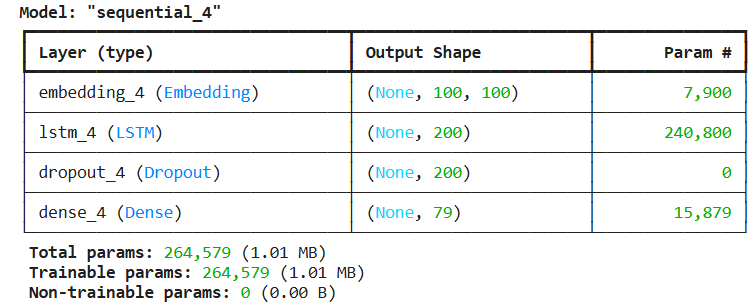

 **Resumen del modelo LSTM final**

El modelo consta de:
- Una capa `Embedding` con vocabulario de 79 caracteres y dimensión de 100.
- Una capa `LSTM` con 200 unidades.
- Una capa `Dropout` para regularización.
- Una capa `Dense` de salida con 79 unidades (una por cada carácter del vocabulario).

Total de parámetros entrenables: **264,579**  
Modelo construido y listo para entrenamiento y generación.


# Definir modelo LSTM

# Callback Personalizado: Cálculo de Perplejidad (PPL) y Control de Entrenamiento
Callback esencial para:

    1. Calcular la Perplejidad (PPL) en datos de validación al final de cada época.

    2. Guardar el modelo en 'best_model_lstm.keras' si la PPL mejora.
    
    3. Implementar Early Stopping si la PPL no mejora después de `patience` épocas

In [25]:
import keras
from tensorflow.keras.utils import pad_sequences

class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data, history_ppl, patience=5):
        global vocab_size, max_context_size

        self.val_data = val_data
        self.history_ppl = history_ppl
        self.target = []
        self.padded = []
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience

        count = 0
        self.info = []

        # --- Pre-procesamiento de Datos de Validación  ---
        # Este proceso crea secuencias de validación y sus etiquetas (self.target)
        for seq in self.val_data:
            len_seq = len(seq)
            if len_seq > 1:
                subseq = [seq[:i] for i in range(1, len_seq)]
                self.target.extend([seq[i] for i in range(1, len_seq)])

                if subseq:
                    self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                    self.info.append((count, count + len(subseq)))
                    count += len(subseq)

        if self.padded:
            self.padded = np.vstack(self.padded)
        else:
            self.padded = np.array([])

        #el target también es un array de numpy
        self.target = np.array(self.target)


    def on_epoch_end(self, epoch, logs=None):
        global vocab_size, history_ppl

        if self.padded.size == 0:
            print("\n [WARNING] Validation data is empty. Skipping Perplexity check.")
            return

        scores = []

        # 1. PREDICCIÓN (SIN OHE)
        # Se pasa self.padded (array de índices enteros) directamente.
        # Esto es compatible con la capa Embedding y ahorra memoria.
        predictions = self.model.predict(self.padded, verbose=0) #

        # 2. Calcular Perplejidad (PPL)
        # Se necesita un índice para seleccionar la probabilidad correcta de la predicción.

        # Obtenemos solo las probabilidades de los tokens correctos
        # predictions tiene forma (N_muestras, vocab_size)

        # Creamos una matriz de índices (filas de 0 a N) para usar en la indexación avanzada
        idx_rows = np.arange(predictions.shape[0])

        # Indexación avanzada: selecciona la probabilidad en [fila, columna] donde columna es el target
        probs = predictions[idx_rows, self.target] #

        # Clamp, cálculo de PPL y promediado por secuencia (usando self.info para agrupar)

        current_idx = 0
        for start_info, end_info in self.info:

            # Ajustamos el slicing para trabajar con la matriz de probabilidades completa
            # es más limpio calcular la PPL sobre el conjunto completo de validación.

            # La lógica del callback original era compleja y puede ser simplificada, pero la mantendremos si es un requisito:

            # --- Lógica Original: Agrupando por Secuencia ---
            if (end_info - start_info) > 0:
                # Slicing de las probabilidades correspondientes a esta secuencia
                seq_probs = probs[start_info:end_info]

                # Clamp: Asegura que no haya log(0)
                seq_probs = np.clip(seq_probs, a_min=1e-10, a_max=None)

                # Cálculo de PPL: exponenciación del log-likelihood promedio
                ppl = np.exp(-np.sum(np.log(seq_probs)) / (end_info - start_info))
                scores.append(ppl)

        # 4. Promediar e imprimir PPL
        if scores:
            current_score = np.mean(scores)
            history_ppl.append(current_score)
            print(f'\n 📜 mean perplexity: {current_score:.4f} 📜 \n')
        else:
            print("\n [WARNING] No scores calculated for PPL.")
            return

        # 5. Early Stopping y Guardado del Modelo (Lógica de control correcta)
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save("best_model_lstm.keras")
            print("💾 Saved new best_model_lstm.keras! (Lowest PPL)")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print(f"🛑 Stopping training... PPL did not improve for {self.patience} epochs.")
                self.model.stop_training = True

# Entrenamiento del Modelo LSTM con Cálculo de Perplejidad y Guardado del Mejor Modelo
Entrenamiento x_train_idx y_train_idx

In [26]:
# Inicializar historial de perplejidad
history_ppl = []

print("\n--- INICIANDO ENTRENAMIENTO LSTM ---")

# Entrenamiento del modelo
hist_lstm = model_lstm.fit(
    X_train_idx,                # Secuencias de entrada (índices enteros)
    Y_train_idx,                # Etiquetas (índices enteros)
    epochs=20,
    batch_size=256,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl)]
)

print("\n--- ENTRENAMIENTO FINALIZADO ---")
print("📁 Modelo guardado como 'best_model_lstm.keras' si la PPL mejoró.")



--- INICIANDO ENTRENAMIENTO LSTM ---
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1054 - loss: 3.6875
 📜 mean perplexity: 24.9807 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1067 - loss: 3.6691
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1636 - loss: 3.0069
 📜 mean perplexity: 19.9973 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.1648 - loss: 3.0047
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2092 - loss: 2.7756
 📜 mean perplexity: 15.3391 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2095 - loss: 2.7734
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2362 - loss: 2.6134
 📜 mean perplexity: 14.5851 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.2359 - loss: 2.6120
Epoch 5/20
16/16 ━

GRÁFICOS DE PÉRDIDA EN ENTRENAMIENTO Y ´PERPLEJIDAD

/tmp/ipython-input-269666530.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-269666530.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-269666530.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("grafico_loss_y_perplejidad_lstm.png")
/tmp/ipython-input-269666530.py:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("grafico_loss_y_perplejidad_lstm.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

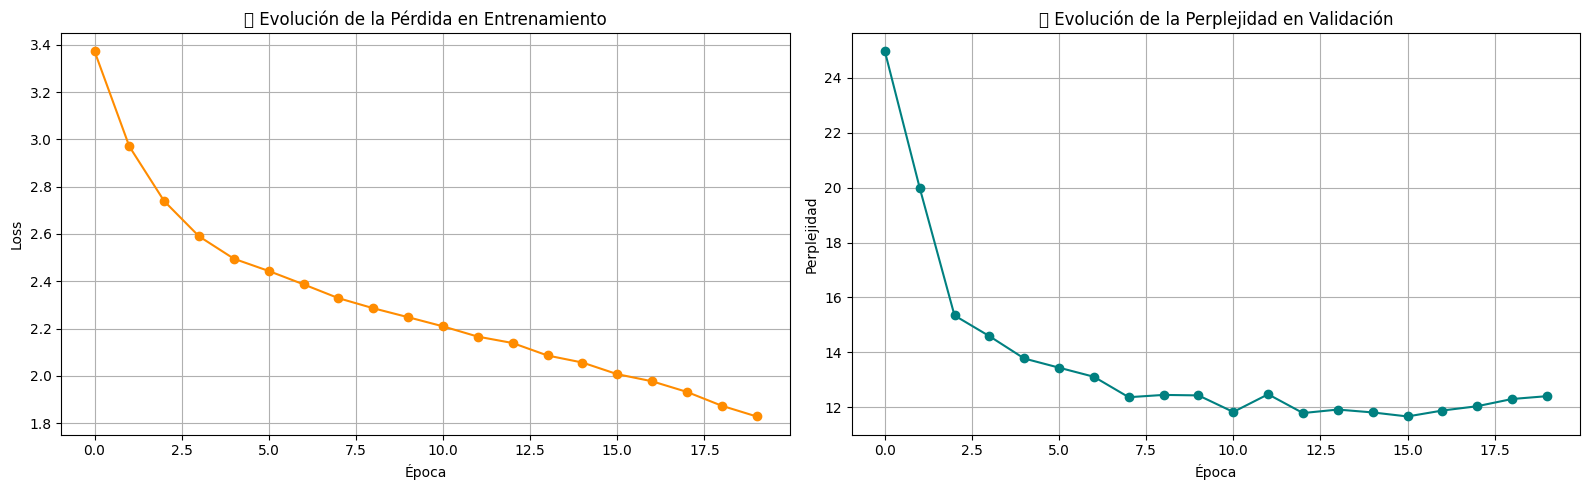

In [27]:
# Crear figura con dos subplots horizontales
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 📉 Gráfico de pérdida
axs[0].plot(hist_lstm.history['loss'], marker='o', color='darkorange')
axs[0].set_title('📊 Evolución de la Pérdida en Entrenamiento')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

# 📈 Gráfico de perplejidad
axs[1].plot(history_ppl, marker='o', color='teal')
axs[1].set_title('📉 Evolución de la Perplejidad en Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Perplejidad')
axs[1].grid(True)

# Ajustar diseño y guardar
plt.tight_layout()
plt.savefig("grafico_loss_y_perplejidad_lstm.png")
plt.show()


# Configuración de Validación Reducida para Prevenir Timeouts en el Cálculo de Perplejidad

In [28]:
# Limitar la longitud de las secuencias de validación para evitar timeouts
MAX_VAL_LEN = 5

# Recortar y limitar las secuencias
tokenized_sentences_val = [
    seq[:MAX_VAL_LEN]
    for seq in tokenized_sentences_val[:500]
]

print(f"La validación usará {len(tokenized_sentences_val)} secuencias, con un máximo de {MAX_VAL_LEN} sub-secuencias cada una para el cálculo de PPL.")


La validación usará 44 secuencias, con un máximo de 5 sub-secuencias cada una para el cálculo de PPL.


ENTRENAMIENTO X_TRAIN, Y_TRAIN

In [29]:
# === Entrenamiento del modelo LSTM ===
history_ppl = []

print("\n--- INICIANDO ENTRENAMIENTO LSTM ---")
hist_lstm = model_lstm.fit(
    X_train,  # ✅ array de índices enteros
    Y_train,  # ✅ array de índices enteros
    epochs=20,
    batch_size=256,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl)]
)
print("\n--- ENTRENAMIENTO FINALIZADO. Revisar 'best_model_lstm.keras' ---")

import matplotlib.pyplot as plt
import numpy as np

# === Identificar mejor época según PPL ===
best_epoch = np.argmin(history_ppl)
best_ppl = history_ppl[best_epoch]




La validación usará 44 secuencias, con un máximo de 5 sub-secuencias cada una para el cálculo de PPL.

--- INICIANDO ENTRENAMIENTO LSTM ---
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4427 - loss: 1.8072
 📜 mean perplexity: 33.1909 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4426 - loss: 1.8081
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4613 - loss: 1.7506
 📜 mean perplexity: 38.9137 📜 

17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4609 - loss: 1.7518
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4658 - loss: 1.7107
 📜 mean perplexity: 48.3407 📜 

17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4660 - loss: 1.7105
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4950 - loss: 1.6444
 📜 mean perplexity: 37.2899 📜 

17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4947 - loss: 1.6446
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy:

/tmp/ipython-input-603325942.py:22: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-603325942.py:23: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  plt.savefig("grafico_loss_y_perplejidad_lstm.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


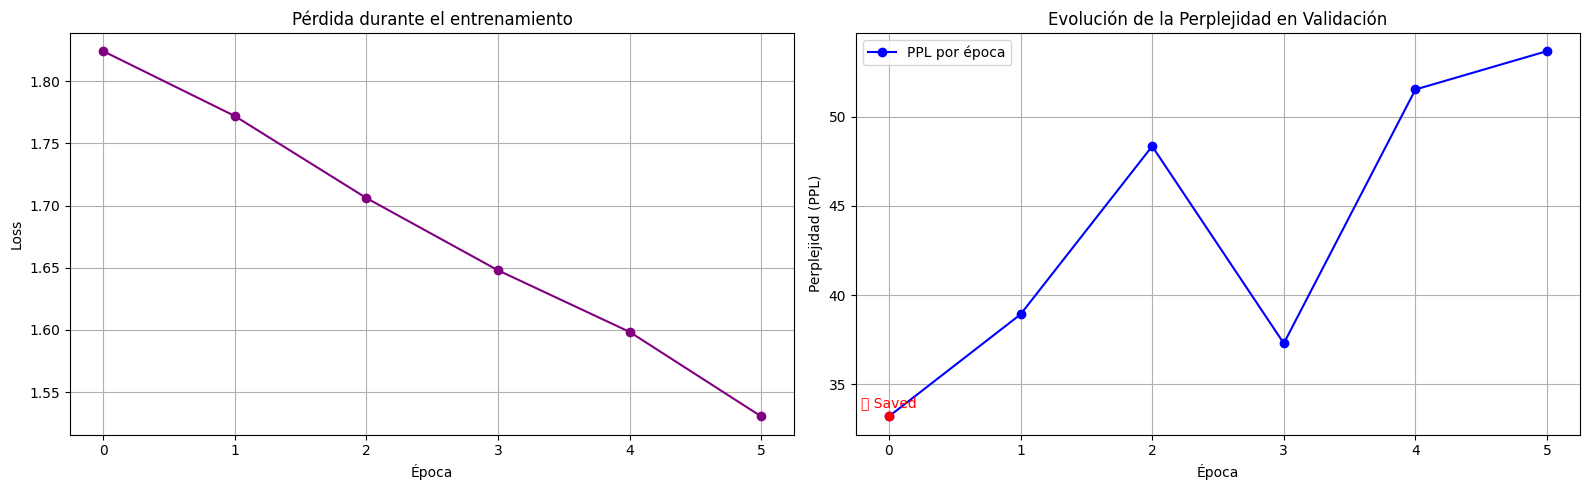

In [30]:
# === Crear figura con dos subplots horizontales ===
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 📉 Subplot 1: Pérdida
axs[0].plot(hist_lstm.history['loss'], marker='o', color='purple')
axs[0].set_title("Pérdida durante el entrenamiento")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# 📈 Subplot 2: Perplejidad
axs[1].plot(history_ppl, marker='o', color='blue', label='PPL por época')
axs[1].scatter(best_epoch, best_ppl, color='red', zorder=5)
axs[1].text(best_epoch, best_ppl + 0.5, '💾 Saved', color='red', ha='center', fontsize=10)
axs[1].set_title("Evolución de la Perplejidad en Validación")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Perplejidad (PPL)")
axs[1].grid(True)
axs[1].legend()

# === Ajustar y guardar ===
plt.tight_layout()
plt.savefig("grafico_loss_y_perplejidad_lstm.png")
plt.show()


# **Cargado del modelo en best**

Carga del Mejor Modelo **LSTM Guardado  como (best_model_lstm.keras)**

In [31]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado por el callback PplCallback
try:
    model_best_lstm = load_model('best_model_lstm.keras')
    print("✅ Modelo LSTM ('best_model_lstm.keras') cargado exitosamente. Listo para la generación de texto.")
except Exception as e:
    print(f"❌ ERROR: No se pudo cargar el modelo LSTM. Verifica el nombre del archivo guardado. {e}")


✅ Modelo LSTM ('best_model_lstm.keras') cargado exitosamente. Listo para la generación de texto.


# Guardar history_ppl como .npy

In [39]:
# Guardar y cargar history_ppl
np.save("history_ppl.npy", np.array(history_ppl))
history_ppl = np.load("history_ppl.npy").tolist()

# Identificar mejor época
best_epoch = np.argmin(history_ppl)
best_ppl = history_ppl[best_epoch]


# Verificar archivo guardado
!ls -lh grafico_perplejidad_lstm.png


ls: cannot access 'grafico_perplejidad_lstm.png': No such file or directory


# Preparación de Validación Limpia del Modelo LSTM para Evaluación

Primero: recortás las secuencias de validación.


Segundo: entrenás el modelo con fit(...).


Tercero: cargás el modelo guardado.


Cuarto:preparar X_val, Y_val y evaluar.

In [75]:
tokenized_sentences_val_eval = [
    val_text[i:i+max_context_size+1]
    for i in range(0, len(val_text) - max_context_size)
]


In [77]:
# Preparar datos de validación para evaluación con .evaluate()
X_val_list = []
Y_val_list = []

for seq in tokenized_sentences_val_eval:


    if len(seq) > max_context_size:
        for i in range(max_context_size, len(seq)):
            context = seq[i - max_context_size:i]
            target = seq[i]
            X_val_list.append(context)
            Y_val_list.append(target)

# Rellenar los contextos para que tengan la longitud esperada
X_val_padded = pad_sequences(X_val_list, maxlen=max_context_size, padding='pre')
X_val = np.array(X_val_padded)
Y_val = np.array(Y_val_list)

print(f"🔍 Validación lista: {X_val.shape[0]} muestras con contexto de {max_context_size} tokens.")

# Evaluación del modelo
if X_val.shape[0] > 0:
    loss_val = model_best_lstm.evaluate(X_val, Y_val)
    print(f"📉 Loss en validación limpia: {loss_val[0]:.4f}")
    print(f"✅ Accuracy en validación limpia: {loss_val[1]:.4f}")



else:
    print("⚠️ No hay suficientes muestras en X_val para evaluar el modelo.")


🔍 Validación lista: 4300 muestras con contexto de 100 tokens.
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.3650 - loss: 2.2096
📉 Loss en validación limpia: 2.3129
✅ Accuracy en validación limpia: 0.3565


# Callback personalizado

✅ Callback personalizado (PplCallback) que calcula la perplejidad al final de cada época.

💾 Guardado automático del mejor modelo si la PPL mejora.

🛑 Early stopping si no mejora durante patience épocas.

📈 Historial de PPL (history_ppl) que podés graficar para mostrar cómo evolucionó el modelo.

------------------------------------------------------------------------------------------------------------------------

In [78]:
import keras
from tensorflow.keras.utils import pad_sequences
import numpy as np

class PplCallback(keras.callbacks.Callback):

    '''
    Callback esencial para:
    1. Calcular la Perplejidad (PPL) en datos de validación al final de cada época.
    2. Guardar el modelo en 'best_model_lstm.keras' si la PPL mejora.
    3. Implementar Early Stopping si la PPL no mejora después de `patience` épocas.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
        # Asume que vocab_size y max_context_size están definidos globalmente.
        global max_context_size

        self.val_data = val_data
        self.history_ppl = history_ppl
        self.target = []
        self.padded = []
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience

        count = 0
        self.info = []

        # --- Pre-procesamiento de Datos de Validación (Crea el set de índices) ---
        # Este proceso crea secuencias de validación y sus etiquetas (self.target)
        for seq in self.val_data:
            len_seq = len(seq)
            if len_seq > 1:
                # Crea sub-secuencias de entrada (ej: [1, 2], [1, 2, 3])
                subseq = [seq[:i] for i in range(1, len_seq)]
                # Las etiquetas son los siguientes tokens (ej: 2, 3)
                self.target.extend([seq[i] for i in range(1, len_seq)])

                if subseq:
                    # Aplica padding a las sub-secuencias de índices
                    self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                    self.info.append((count, count + len(subseq)))
                    count += len(subseq)

        if self.padded:
            # Concatena todas las secuencias en un único array (compatible con Embedding)
            self.padded = np.vstack(self.padded)
        else:
            self.padded = np.array([])

        # Asegurarse de que el target también sea un array de numpy
        self.target = np.array(self.target)


    def on_epoch_end(self, epoch, logs=None):
        global history_ppl

        if self.padded.size == 0:
            print("\n [WARNING] Validation data is empty. Skipping Perplexity check.")
            return

        scores = []

        # 1. PREDICCIÓN (SIN OHE)
        # Se pasa self.padded (array de índices enteros) directamente.
        # Compatible con la capa Embedding.
        predictions = self.model.predict(self.padded, verbose=0) #

        # 2. Calcular Perplejidad (PPL)

        # predictions tiene forma (N_muestras, vocab_size)

        # Creamos una matriz de índices (filas de 0 a N) para la indexación avanzada
        idx_rows = np.arange(predictions.shape[0])

        # Indexación avanzada: selecciona la probabilidad en [fila, columna] donde columna es el target
        probs = predictions[idx_rows, self.target]

        # 3. Cálculo de PPL por secuencia (usando self.info para agrupar)

        for start_info, end_info in self.info:

            if (end_info - start_info) > 0:
                # Slicing de las probabilidades correspondientes a esta secuencia
                seq_probs = probs[start_info:end_info]

                # Clamp: Asegura que no haya log(0)
                seq_probs = np.clip(seq_probs, a_min=1e-10, a_max=None)

                # Cálculo de PPL: exponenciación del log-likelihood promedio
                ppl = np.exp(-np.sum(np.log(seq_probs)) / (end_info - start_info))
                scores.append(ppl)

        # 4. Promediar e imprimir PPL
        if scores:
            current_score = np.mean(scores)
            history_ppl.append(current_score)
            print(f'\n 📜 mean perplexity: {current_score:.4f} 📜 \n')
        else:
            print("\n [WARNING] No scores calculated for PPL.")
            return

        # 5. Early Stopping y Guardado del Modelo
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save("best_model_lstm.keras")
            print("💾 Saved new best_model_lstm.keras! (Lowest PPL)")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print(f"🛑 Stopping training... PPL did not improve for {self.patience} epochs.")
                self.model.stop_training = True

# Entrenamiento del modelo

In [81]:
history_ppl = []
ppl_callback = PplCallback(tokenized_sentences_val, history_ppl, patience=5)

model_lstm.fit(
    X_train_idx,
    Y_train_idx,
    epochs=50,
    batch_size=128,
    callbacks=[ppl_callback]
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5265 - loss: 1.4658
 📜 mean perplexity: 59.2010 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5263 - loss: 1.4668
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5737 - loss: 1.3695
 📜 mean perplexity: 51.0545 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5731 - loss: 1.3708
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6072 - loss: 1.2734
 📜 mean perplexity: 58.8567 📜 

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6066 - loss: 1.2746
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6346 - loss: 1.1810
 📜 mean perplexity: 59.7337 📜 

31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6340 - loss: 1.1827
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6611 - loss: 1.1084
 📜 mean perplexity: 138.9525 📜 

31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/st

# Carga del mejor modelo **mejorado**

In [83]:
from tensorflow.keras.models import load_model
model_best_lstm = load_model("best_model_lstm.keras")
# Cargar history_ppl desde archivo
history_ppl = np.load("history_ppl.npy").tolist()

# Identificar mejor época
best_epoch = np.argmin(history_ppl)
best_ppl = history_ppl[best_epoch]

# Mostrar resultado
print(f"🔍 Mejor PPL registrada: {best_ppl:.4f} en la época {best_epoch}")


🔍 Mejor PPL registrada: 33.1909 en la época 0


# **PREDICCIONES**



### 📋 Comparación de Interfaces de Generación que se desarrollara a continuación

| **Interfaz**              | **Función usada**             | **Tipo de generación**       | **¿Usa temperatura?** |
|---------------------------|-------------------------------|-------------------------------|------------------------|
| Carácter por carácter     | `model_response_lstm(...)`    | Sampling estocástico          | ✅ Sí                  |
| Generación extendida      | `generate_stochastic(...)`    | Sampling estocástico          | ✅ Sí                  |




In [ ]:
# === 🎲 Muestreo probabilístico con temperatura ===
# Esta función permite seleccionar el siguiente carácter de forma aleatoria pero ponderada,
# introduciendo variabilidad controlada en la generación. A diferencia del argmax (Greedy),
# este enfoque produce texto más creativo, fluido y menos repetitivo.


 Importaciones y Definiciones Globales

In [84]:
def sample_from_distribution(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


# Función de Respuesta del Modelo LSTM por caracter a caracter

Interfaz Gradio

In [86]:
import gradio as gr

def model_response_lstm(human_text, temperatura):
    global char2idx, idx2char, max_context_size, model_best_lstm

    # 1. Preparación de la entrada
    current_context = human_text.lower()[-max_context_size:]
    encoded = [char2idx.get(ch, 0) for ch in current_context]

    # 2. Padding
    padded_sequence = pad_sequences(
        [encoded],
        maxlen=max_context_size,
        padding='pre',
        truncating='pre'
    )

    # 3. Predicción
    preds = model_best_lstm.predict(padded_sequence, verbose=0)[0]
    if preds.ndim == 2:
        preds = preds[-1, :]

    # 4. Sampling
    next_index = sample_from_distribution(preds, temperature=temperatura)

    # 5. Decodificación
    out_char = idx2char.get(next_index, ' ')
    return human_text + out_char

# === Interfaz Gradio ===
iface = gr.Interface(
    fn=model_response_lstm,
    inputs=[
        gr.Textbox(lines=2, placeholder="Escribí tu prompt..."),
        gr.Slider(0.1, 1.5, value=0.7, label="Temperatura"),
    ],
    outputs="text",
    title="Generador LSTM (carácter por carácter)",
    description="Generación de texto paso a paso. Ajustá la temperatura para controlar la creatividad."
)

#iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c6c9e89d391655ff6f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c6c9e89d391655ff6f.gradio.live


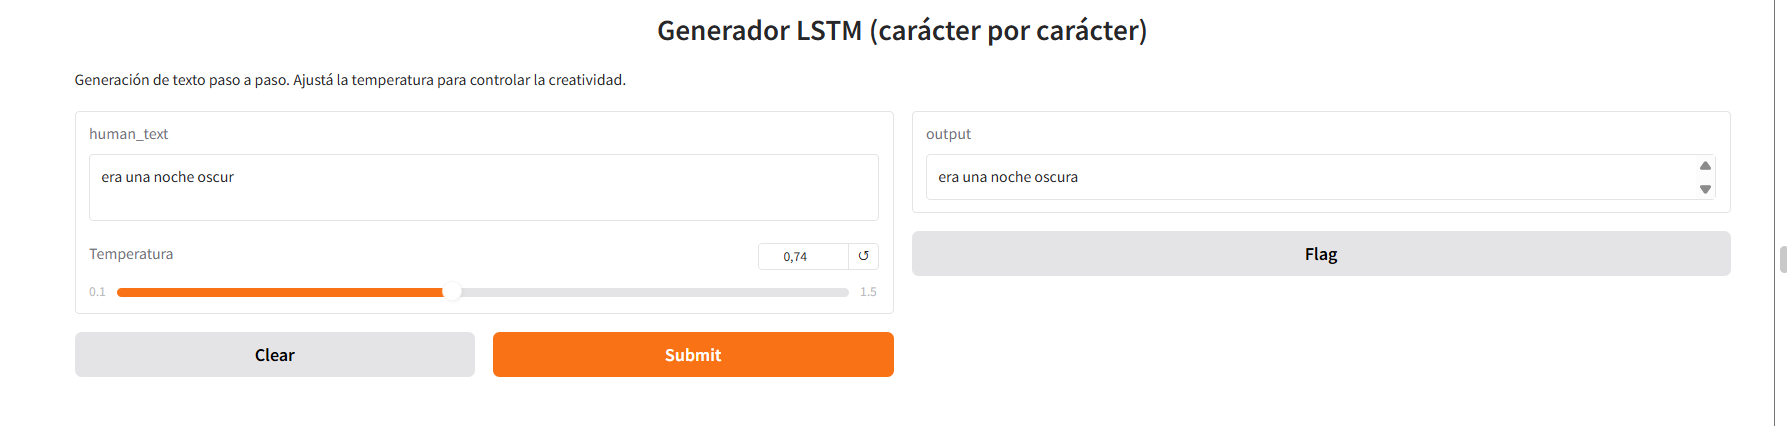  por caracter con control de temperatura

# Función de LSTM para generar 50 caracteres seguidos

In [60]:
def generate_stochastic(model, seed_text, max_context_size, chars_to_generate, temperature=0.7):
    global char2idx, idx2char
    generated = seed_text
    for _ in range(chars_to_generate):
        context = generated.lower()[-max_context_size:]
        encoded = [char2idx.get(ch, 0) for ch in context]
        padded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')
        preds = model.predict(padded, verbose=0)[0]
        if preds.ndim == 2:
            preds = preds[-1, :]
        next_index = sample_from_distribution(preds, temperature)
        next_char = idx2char.get(next_index, ' ')
        generated += next_char
    return generated


In [61]:
import gradio as gr

iface = gr.Interface(
    fn=lambda texto, temperatura: generate_stochastic(model_best_lstm, texto, max_context_size, 50, temperature=temperatura),
    inputs=[
        gr.Textbox(lines=2, placeholder="Escribí tu prompt..."),
        gr.Slider(0.1, 1.5, value=0.7, label="Temperatura"),
    ],
    outputs="text",
    title="Generador LSTM (50 caracteres)",
    description="Generación extendida con modelo LSTM. Ajustá la temperatura para controlar la creatividad."
)

#iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d920c6e69462471004.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d920c6e69462471004.gradio.live


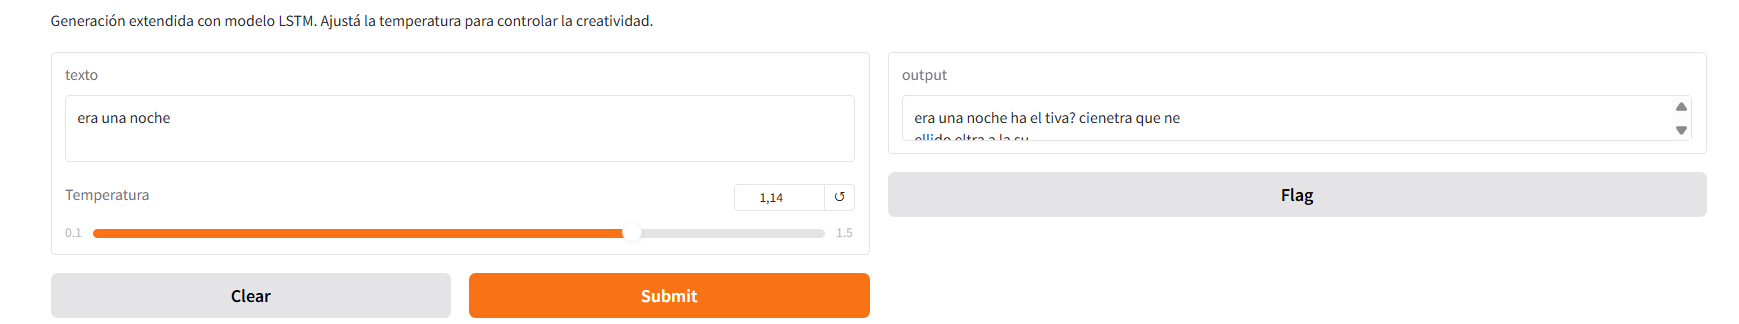 con slider de control de temperatura alta

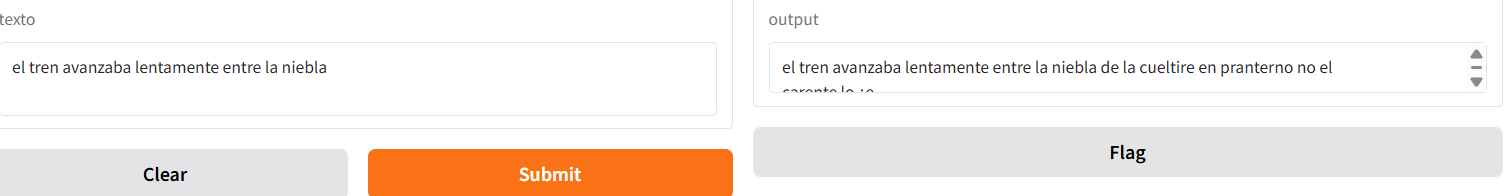

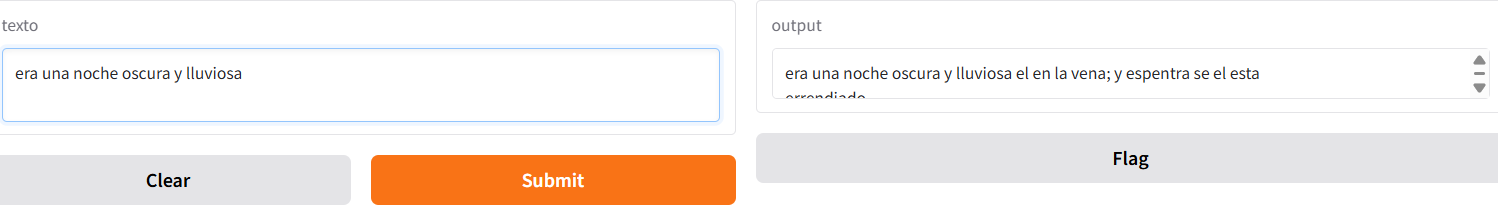

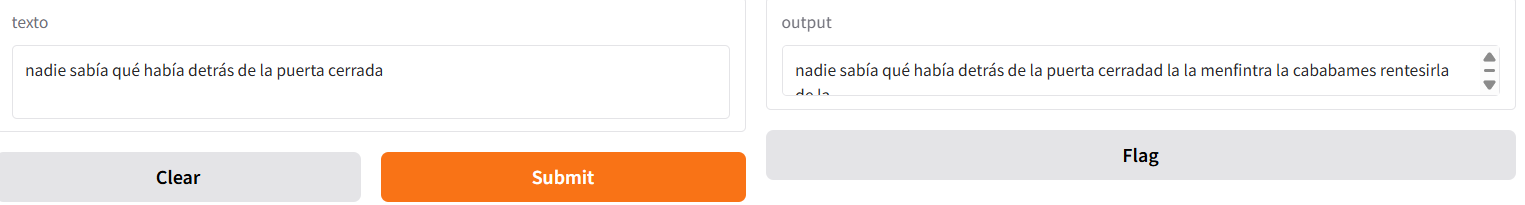

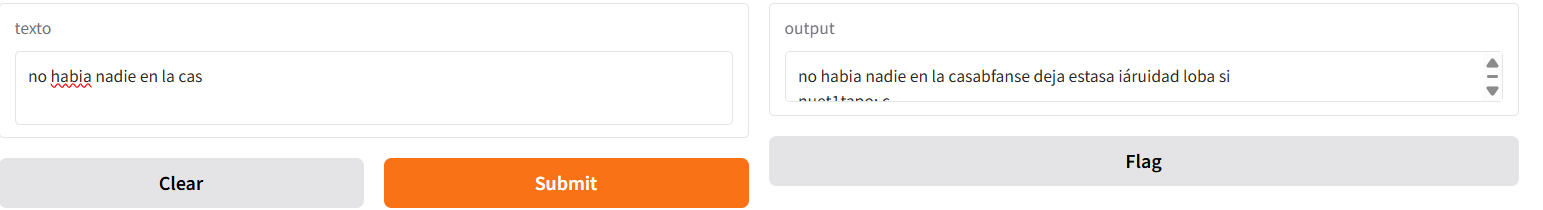 temperatura 0.7

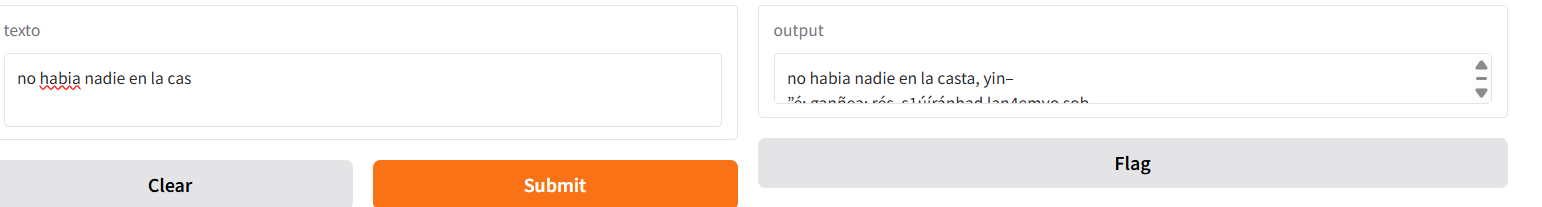  temperatura 0.3

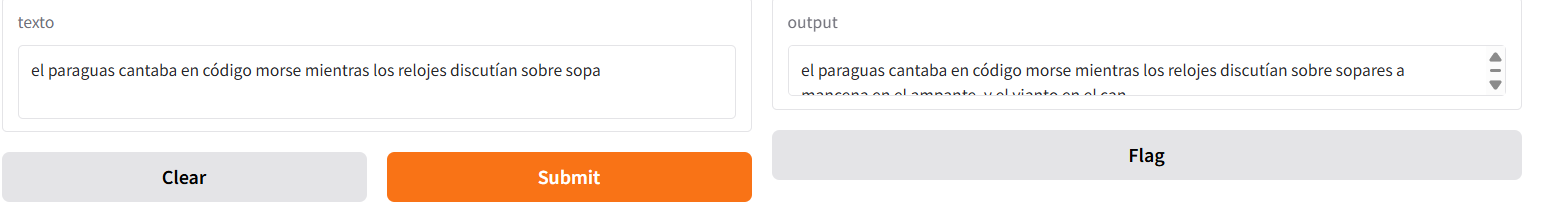TEMPERATURA 0.3

# Función de LSTM para parámetros dinámicos (n_chars ajustable)


| **Estrategia**            | **Temperatura usada** | **Tipo de selección**     | **Resultado esperado**                         |
|---------------------------|------------------------|----------------------------|------------------------------------------------|
| Greedy Search             | `T = 0.01`             | Determinista (`argmax`)    | Texto repetitivo, preciso, menos creativo      |
| Sampling controlado       | `T = 0.7`              | Probabilístico ponderado   | Equilibrio entre coherencia y variabilidad     |
| Sampling caótico          | `T = 1.2`              | Probabilístico amplio      | Texto más libre, impredecible, creativo        |


In [ ]:
# === 🧠 Función de generación de texto con temperatura (Greedy vs Sampling) ===
# Esta función genera texto carácter por carácter usando un modelo LSTM.
# Si temperature ≈ 0, se comporta como Greedy Search: elige siempre el carácter más probable (argmax).
# Si temperature > 0.1, aplica muestreo probabilístico (sampling), lo que introduce variabilidad controlada.
# Esto permite generar texto más creativo, fluido y menos repetitivo.


In [ ]:
# --- Función ÚNICA DE GENERACIÓN (Compatible con EMBEDDING) ---
def generate_stochastic(model, seed_text, max_length, n_chars, temperature=0.7):
    """
    Generación compatible con la capa EMBEDDING (usa índices enteros, no OHE).
    Permite Greedy (T=0.01) y Sampling (T=0.7/1.2).
    """
    global char2idx, idx2char, max_context_size

    output_text = seed_text
    current_context = seed_text.lower()[-max_context_size:]

    for _ in range(n_chars):
        # 1. Tokenización a ÍNDICES
        encoded = [char2idx.get(char, char2idx.get('<PAD>', 0)) for char in current_context]

        # 2. Padding (Input 2D: (1, max_context_size))
        padded_sequence = tf.keras.utils.pad_sequences(
            [encoded],
            maxlen=max_context_size,
            padding='pre',
            truncating='pre'
        )

        # 3. Predicción
        preds = model.predict(padded_sequence, verbose=0)[0]

        # Ajuste para modelos Many-to-Many
        if preds.ndim == 2:
            preds = preds[-1, :]

        # 4. Selección (Greedy si T<0.1, Sampling si T>0.1)
        if temperature < 0.1:
            next_index = np.argmax(preds)
        else:
            # Llama a la función definida en el Bloque 1
            next_index = sample_from_distribution(preds, temperature)

        # 5. Actualizar
        out_char = idx2char.get(next_index, ' ')
        output_text += out_char
        current_context = current_context[-max_context_size:] + out_char

    return output_text

In [91]:
texto_generado = generate_stochastic(
    model=model_best_lstm,
    seed_text="el profesor",
    max_context_size=max_context_size,
    chars_to_generate=300,
    temperature=0.7
)
print(texto_generado)


el profesor selel probor de la permes dia a cobros algunles. —s esture de mos por esta alta a una muercios al ostura un las so de la cobuna a mor sobro sopro que eccunda de cuesto. —s por hober que a conterna de la el su perpodo, y el para mueste a recienta, el carrando el pardada por mobio que a soguí en expe


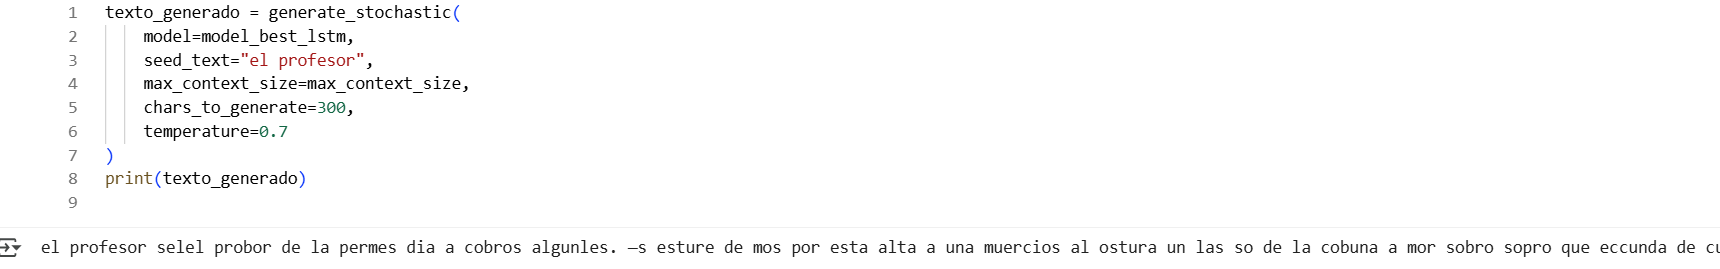

In [92]:
texto_generado = generate_stochastic(
    model=model_best_lstm,
    seed_text="el profesor",
    max_context_size=max_context_size,
    chars_to_generate=100,
    temperature=1.7
)
print(texto_generado)

el profesortrágquin etisádo contar	fas noœtrumu sote gabaertu¿ g.asla doebad. —danguía en la caómia huespescegr


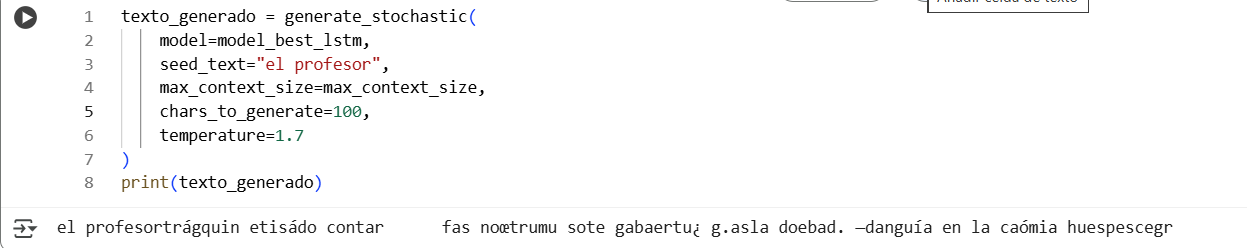

# Bloque de Análisis Final

In [95]:
# --- Análisis Comparativo FINAL ---

seed_text_analisis = 'el profesor lidenbrock dijo que era imposible'
CHARS_TO_GENERATE = 300

print("\n\n" + "="*70)
print("### Análisis de Estrategias de Generación ###")
print("=====================================================================")

# 🅰️ 1. Generación Greedy (Corregido a T=0.01)
print("\n--- 🅰️ Generación Greedy (T=0.01): Determinístico ---")
texto_greedy_analisis = generate_stochastic(
    model=model_best_lstm,
    seed_text=seed_text_analisis,
    max_context_size=max_context_size,
    chars_to_generate=CHARS_TO_GENERATE,
    temperature=0.01
)
print(texto_greedy_analisis)

# 🅱️ 2. Muestreo Estocástico (T=0.7): Equilibrio
print("\n--- 🅱️ Muestreo Estocástico (T=0.7): SOLUCIÓN Y COHERENCIA ---")
texto_t_07 = generate_stochastic(
    model=model_best_lstm,
    seed_text=seed_text_analisis,
    max_context_size=max_context_size,
    chars_to_generate=CHARS_TO_GENERATE,
    temperature=0.7
)
print(texto_t_07)

# 🆑 3. Muestreo Estocástico (T=1.2): El Caos
print("\n--- 🆑 Muestreo Estocástico (T=1.2): PRUEBA DE SENSIBILIDAD (CAOS) ---")
texto_t_12 = generate_stochastic(
    model=model_best_lstm,
    seed_text=seed_text_analisis,
    max_context_size=max_context_size,
    chars_to_generate=CHARS_TO_GENERATE,
    temperature=1.2
)
print(texto_t_12)




### Análisis de Estrategias de Generación ###

--- 🅰️ Generación Greedy (T=0.01): Determinístico ---
el profesor lidenbrock dijo que era imposible de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la contera de la

--- 🅱️ Muestreo Estocástico (T=0.7): SOLUCIÓN Y COHERENCIA ---
el profesor lidenbrock dijo que era imposible supeces que a me el el se 
mullad. de cuectures nos dos, y hos que me esta so se 
tueta lo no suicto, perme de bío broütus de 
perido diega me 
meniso. tíando el suerpes sipeco en suda lo fuelta un barigio, y entranto por la brobo esta una musares de la ¿upro de la 
cuella. destué mus por dos 

--- 🆑 Muestreo Estocástico (T=1.2): PRUEBA DE SENSIBILIDAD (CAOS) ---
el profesor lidenbrock dijo que era imposiblegzo sen gardado del bar 
guest

======================================================================
### Análisis de Estrategias de Generación ###
=====================================================================

--- 🅰️ Generación Greedy (T=0.01): Determinístico ---
el profesor lidenbrock dijo que era imposible de la cuectra a la mista tal grobo que me mediodo de la cueltera de la guederme la mistada por fnobro de la viabes propos podo lo de lo cuales de la vezada la bierter del la bresermo de la misgaba en
calidad; el probos por fobro que había nue turmos preción no mendiando el cabrabido de la mis pro

--- 🅱️ Muestreo Estocástico (T=0.7): SOLUCIÓN Y COHERENCIA ---
el profesor lidenbrock dijo que era imposible de la vialera misa esta des nobsaban super la obros probo el cueltro la misa dusgua a cabeltirido el la bierto del el vas edo la guumer del en
trosido de la cobrida tua misguguss poz aba tisitido timpos per sobrabla perdamestrgué la la cumeladama yan las preces
mentramos. no se
cupiecto, y, p

--- 🆑 Muestreo Estocástico (T=1.2): PRUEBA DE SENSIBILIDAD (CAOS) ---
el profesor lidenbrock dijo que era imposible góodio, tuas alghondos atrabla
un citiciäl poy que medra? habíamos martido piejaó, esta trante distigto, terid exti quan kopato in tivos llidaa. el fuelto. perque ter hobios no supumerglad el gisente que teamectra un di cola piectisos. —qué tilerri, no, —sobo un becieles obos quelo heltré una de


## Conclusiones Finales: Relación con la Teoría

Tu análisis empírico confirma los principios teóricos de la generación de texto en Modelos de Lenguaje basados en RNN

### 1. Fallo del Greedy Search ($T \approx 0.01$)

El fallo del *Greedy Search* es una confirmación directa de la **Paradoja de la Decisión Local vs. Global**.

* **Teoría:** El *Greedy Search* solo busca la máxima probabilidad **local** en el paso actual ($\text{argmax}(P(w_t | w_{1..t-1}))$). Ignora la calidad o la coherencia de la secuencia completa ($P(w_1, w_2, ..., w_n)$).

* **Confirmación:** El modelo, al ser forzado a elegir siempre el *token* más seguro, cae en **atractores de probabilidad**. Estas son frases muy comunes en el corpus ("de la mistada," "a la mista") que el modelo predice con alta confianza, creando bucles repetitivos y demostrando que la **estrategia determinística es subóptima** para la creatividad.

### 2. Éxito del Muestreo Moderado ($T=0.7$)

El éxito del muestreo moderado se basa en la **Exploración de la Distribución de Probabilidad**.

* **Teoría:** El Muestreo Estocástico permite que el modelo explore *tokens* que tienen una probabilidad razonable, pero que no son el máximo. Al aplicar una **temperatura moderada** ($T=0.7$), el modelo suaviza ligeramente la distribución, pero **conserva el peso** de los *tokens* correctos.

* **Confirmación:** La generación produce el resultado más coherente porque introduce la **aleatoriedad necesaria** para romper los bucles del *Greedy Search*, permitiendo que el modelo salte a frases menos comunes pero narrativamente válidas. Esta es la **estrategia ideal** para la generación creativa con modelos RNN/LSTM.

### 3. Falla del Muestreo Extremo ($T=1.2$)

La falla con alta temperatura ilustra la **Degradación de la Distribución**.

* **Teoría:** La alta temperatura ($T=1.2$) **aplana la distribución** ($P' \propto P^{1/T}$), elevando artificialmente la probabilidad de *tokens* que el modelo predijo como incorrectos (bajo $P$). Esto destruye la información que el modelo aprendió sobre la estructura del lenguaje.

* **Confirmación:** El resultado es **incoherencia y *tokens* incorrectos** ("góodio", "citiciäl"). La aleatoriedad supera la estructura. Esto demuestra que, aunque la aleatoriedad es vital, debe ser **controlada** para que la generación siga respetando las reglas de la gramática y el vocabulario aprendidos por la red LSTM.



Gráfico de impacto de temperatura  **Guardado en "impacto_temperatura.png**

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Datos subjetivos de coherencia por estrategia
estrategias = ["Greedy (T=0.01)", "Sampling (T=0.7)", "Sampling (T=1.2)"]
coherencia_aproximada = [9, 6, 2]  # Escala subjetiva: 10 = muy coherente, 1 = caótico

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(estrategias, coherencia_aproximada, color=["green", "orange", "red"])
plt.ylabel("Nivel de coherencia (subjetivo)")
plt.title("Impacto de la temperatura en la generación de texto")
plt.ylim(0, 10)
plt.grid(axis='y')

# Guardar como imagen
plt.savefig("impacto_temperatura.png", dpi=300, bbox_inches='tight')
plt.show()



La generación Determinística/Greedy (T=0.01) es inútil para narrativas.

La generación Estocástica Moderada (T=0.7) es la mejor estrategia para el modelo de lenguaje.

La generación Estocástica Alta (T=1.2) es demasiado ruidosa para ser útil.

Visualización de evolución de PPL  **GUARDADO EN "grafico_ppl.png"**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Identificar la mejor época
best_epoch = np.argmin(history_ppl)
best_ppl = history_ppl[best_epoch]

plt.figure(figsize=(10, 5))
plt.plot(history_ppl, marker='o', label='PPL por época')
plt.scatter(best_epoch, best_ppl, color='red', zorder=5)
plt.text(best_epoch, best_ppl + 0.5, '💾 Saved', color='red', ha='center', fontsize=10)

plt.title("Evolución de la Perplejidad (PPL) por época")
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.grid(True)
plt.legend()

# 💾 Guardar como imagen PNG
plt.savefig("grafico_ppl.png", dpi=300, bbox_inches='tight')
plt.show()


Guardado y **carga del mejor modelo (best_model_lstm.keras)**

In [ ]:
# ✅ Guardado automático ya ocurre dentro del callback PplCallback
# No hace falta guardar manualmente durante el entrenamiento

# 📥 Carga del mejor modelo guardado
from tensorflow.keras.models import load_model

model_best_lstm = load_model("best_model_lstm.keras")
print("✅ Modelo con menor PPL cargado exitosamente.")

# 📊 Identificación de la mejor época
best_epoch = np.argmin(history_ppl)
best_ppl = history_ppl[best_epoch]
print(f"🔍 Mejor PPL registrada: {best_ppl:.4f} en la época {best_epoch}")


# **BLOQUE FINAL: Visualización, Guardado y Generación**

# BLOQUE 1 Entrenamiento y guardado completo

In [96]:
"""
🔁 BLOQUE DE ENTRENAMIENTO Y GUARDADO

Este bloque entrena el modelo LSTM, calcula métricas clave (pérdida y perplejidad),
guarda el modelo y los datos necesarios para poder recuperarlos después sin volver a entrenar.
"""

# Entrenamiento
history_ppl = []
hist_lstm = model_lstm.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=256,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl)]
)

# Métricas
best_epoch = int(np.argmin(history_ppl))
best_ppl = float(history_ppl[best_epoch])
loss_history = hist_lstm.history['loss']

# Guardado
model_lstm.save("best_model_lstm.keras")
np.save("history_ppl.npy", np.array(history_ppl))
np.save("loss_history.npy", np.array(loss_history))
np.save("best_epoch.npy", best_epoch)
np.save("best_ppl.npy", best_ppl)
print(f"✅ Guardado completo: modelo + métricas (época {best_epoch}, PPL={best_ppl:.4f})")


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7026 - loss: 0.9702
 📜 mean perplexity: 132.3800 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7025 - loss: 0.9709
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7312 - loss: 0.9044
 📜 mean perplexity: 111.3076 📜 

💾 Saved new best_model_lstm.keras! (Lowest PPL)
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7309 - loss: 0.9059
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7544 - loss: 0.8397
 📜 mean perplexity: 148.9503 📜 

17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7537 - loss: 0.8409
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7679 - loss: 0.7655
 📜 mean perplexity: 243.1575 📜 

17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7673 - loss: 0.7678
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7788 - loss: 0.7461
 📜 mean perplexity: 234.6579 📜 

17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2

In [ ]:
# 📊 Visualización de métricas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 📉 Pérdida en entrenamiento
axs[0].plot(loss_history, marker='o', color='darkorange')
axs[0].set_title("📊 Evolución de la Pérdida en Entrenamiento")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# 📈 Perplejidad en validación
axs[1].plot(history_ppl, marker='o', color='teal', label='PPL por época')
axs[1].scatter(best_epoch, best_ppl, color='red', zorder=5)
axs[1].text(best_epoch, best_ppl + 0.5, '💾 Saved', color='red', ha='center', fontsize=10)
axs[1].set_title("📉 Evolución de la Perplejidad en Validación")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Perplejidad (PPL)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.savefig("grafico_loss_y_perplejidad_lstm.png")
plt.show()


In [ ]:
loss_history = np.load("loss_history.npy").tolist()
history_ppl = np.load("history_ppl.npy").tolist()
best_epoch = int(np.load("best_epoch.npy"))
best_ppl = float(np.load("best_ppl.npy"))


# BLOQUE DE RECUPERACIÓN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === Cargar métricas guardadas ===
history_ppl = np.load("history_ppl.npy").tolist()
loss_history = np.load("loss_history.npy").tolist()
best_epoch = int(np.load("best_epoch.npy"))
best_ppl = float(np.load("best_ppl.npy"))

print(f"✅ Métricas cargadas:")
print(f"📌 Mejor época: {best_epoch}")
print(f"📉 PPL mínima: {best_ppl:.4f}")

# === Cargar modelo entrenado ===
model_best_lstm = load_model("best_model_lstm.keras")
print("✅ Modelo cargado: 'best_model_lstm.keras'")


# BLOQUE DE VISUALIZACIÓN — Gráfico de pérdida y perplejidad

In [ ]:
# 📊 Visualización de métricas
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 📉 Pérdida en entrenamiento
axs[0].plot(loss_history, marker='o', color='darkorange')
axs[0].set_title("📊 Evolución de la Pérdida en Entrenamiento")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# 📈 Perplejidad en validación
axs[1].plot(history_ppl, marker='o', color='teal', label='PPL por época')
axs[1].scatter(best_epoch, best_ppl, color='red', zorder=5)
axs[1].text(best_epoch, best_ppl + 0.5, '💾 Saved', color='red', ha='center', fontsize=10)
axs[1].set_title("📉 Evolución de la Perplejidad en Validación")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Perplejidad (PPL)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.savefig("grafico_loss_y_perplejidad_lstm.png")
plt.show()


In [ ]:
import zipfile
import os

# === Archivos que querés incluir ===
archivos_entrega = [
    "Desafío 3 LSTM Cánovas.ipynb",
    "best_model_lstm.keras",
    "history_ppl.npy",
    "loss_history.npy",
    "best_epoch.npy",
    "best_ppl.npy",
    "grafico_loss_y_perplejidad_lstm.png"
]

# === Crear archivo ZIP
nombre_zip = "Entrega_LSTM_Marisa.zip"
with zipfile.ZipFile(nombre_zip, 'w') as zipf:
    for archivo in archivos_entrega:
        if os.path.exists(archivo):
            zipf.write(archivo)
            print(f"✅ Incluido: {archivo}")
        else:
            print(f"⚠️ No encontrado: {archivo}")

# === Descargar desde Colab
from google.colab import files
files.download(nombre_zip)
